# Raster Calcuations in Python

## ❓ Questions
- How do I perform calculations on rasters and extract pixel values for defined locations?


## ❗ Objectives
- Carry out operations with two rasters using Python’s built-in math operators.
- Reclassify a continuous raster to a categorical raster.


# Introduction
---

We often want to combine values of and perform calculations on rasters to create a new output raster. This notebook covers how to perform basic math operations using raster datasets. It also illustrates how to match rasters with different resolutions so that they can be used in the same calculation. As an example, we will calculate a vegetation index over one of the satellite scenes.

## Normalized Difference Vegetation Index (NDVI)

Suppose we are interested in monitoring vegetation fluctuations using satellite remote sensors. Scientists have defined a vegetation index to quantify the amount of green leaf vegetation using the light reflected in different wavelengths. This index, named Normalized Difference Vegetation Index (NDVI), exploits the fact that healthy green leaves strongly absorb red visible light while they mostly reflect light in the near infrared (NIR). The NDVI is computed as:
$$
NDVI=NIR−redNIR+red
$$
where NIR
and red label the reflectance values of the corresponding wavelengths. NDVI values range from -1 to +1. Values close to one indicate high density of green leaves. Poorly vegetated areas typically have NDVI values close to zero. Negative NDVI values often indicate cloud and water bodies.


![NDVI](../notebook_pictures/PONE-NDVI3.jpg)  
> Source: Wu C-D, McNeely E, Cedeño-Laurent JG, Pan W-C, Adamkiewicz G, Dominici F, et al. (2014) Linking Student Performance in Massachusetts Elementary Schools with the “Greenness” of School Surroundings Using Remote Sensing. PLoS ONE 9(10): e108548. https://doi.org/10.1371/journal.pone.0108548


See also: [Wikipedia Normalized difference vegetation index (Rationale)](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index#Rationale)

## Load and crop the Data

For this notebook, we will use one of the Sentinel-2 scenes that we have already employed in the previous episodes.

In [39]:
# From the previous lessons...
import os
from os.path import join

product_dir_textfile = "product_dir.txt"

with open(product_dir_textfile, 'r') as f:
    base_product_dir = f.readline()

product_dir = join(base_product_dir, 'GRANULE')
L2_dirname = os.listdir(product_dir)[0]
product_dir = join(product_dir, L2_dirname)
product_dir = join(product_dir, 'IMG_DATA', 'R60m')

# Get a dictionary of filenames
image_paths = {}
for fname in os.listdir(product_dir):
    fpath = join(product_dir, fname)
    file_band = fname.split('_')[2]
    image_paths[file_band] = fpath

image_paths

{'B12': '/data/ASDAF_Workshop_Materials_Remote_Sensing_Intro/notebooks/workshop_data/S2A_MSIL2A_20230824T021351_N0509_R060_T50HMK_20230824T070459/S2A_MSIL2A_20230824T021351_N0509_R060_T50HMK_20230824T070459.SAFE/GRANULE/L2A_T50HMK_A042671_20230824T022008/IMG_DATA/R60m/T50HMK_20230824T021351_B12_60m.jp2',
 'TCI': '/data/ASDAF_Workshop_Materials_Remote_Sensing_Intro/notebooks/workshop_data/S2A_MSIL2A_20230824T021351_N0509_R060_T50HMK_20230824T070459/S2A_MSIL2A_20230824T021351_N0509_R060_T50HMK_20230824T070459.SAFE/GRANULE/L2A_T50HMK_A042671_20230824T022008/IMG_DATA/R60m/T50HMK_20230824T021351_TCI_60m.jp2',
 'WVP': '/data/ASDAF_Workshop_Materials_Remote_Sensing_Intro/notebooks/workshop_data/S2A_MSIL2A_20230824T021351_N0509_R060_T50HMK_20230824T070459/S2A_MSIL2A_20230824T021351_N0509_R060_T50HMK_20230824T070459.SAFE/GRANULE/L2A_T50HMK_A042671_20230824T022008/IMG_DATA/R60m/T50HMK_20230824T021351_WVP_60m.jp2',
 'B06': '/data/ASDAF_Workshop_Materials_Remote_Sensing_Intro/notebooks/workshop_da

In [8]:
import rioxarray
# Load B04 (red) and B08 or B8A (nir)
raster_red = rioxarray.open_rasterio(image_paths['B04'], masked=True)
raster_nir = rioxarray.open_rasterio(image_paths['B8A'], masked=True)

Let’s also restrict our analysis to the same area defined in the previous episode by clipping the rasters using a bounding box

In [13]:
# Load in AOI
import geopandas as gpd

john_forrest_poly_fname = "../data/john_forrest_rough.shp"
AOI_4326 =  gpd.read_file(john_forrest_poly_fname)
AOI = AOI_4326.to_crs(raster_red.rio.crs)

red_clip = raster_red.rio.clip_box(*AOI.total_bounds)
nir_clip = raster_nir.rio.clip_box(*AOI.total_bounds)

We can now plot the two rasters. Using the `robust=True` option, color values are stretched between the 2nd and 98th percentiles of the data, which results in clearer distinctions between high and low reflectances

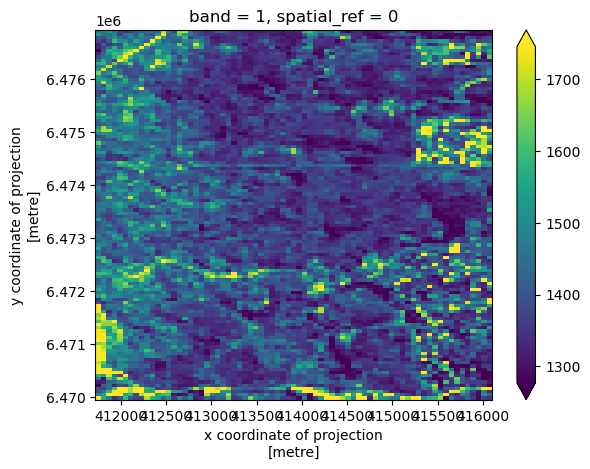

In [18]:
red_clip.plot(robust=True)

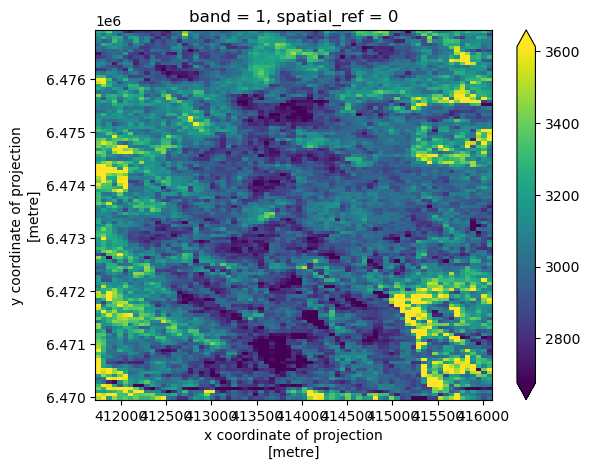

In [19]:
nir_clip.plot(robust=True)

# Raster Math 
We can perform raster calculations by subtracting (or adding, multiplying, etc.) two rasters. In the geospatial world, we call this “raster math”, and typically it refers to operations on rasters that have the same width and height (including nodata pixels). We can check the shapes of the two rasters in the following way:

In [20]:
print(red_clip.shape, nir_clip.shape)

(1, 116, 73) (1, 116, 73)


Both rasters match, but to build good habits let's `reproject_match` anyway.

In [22]:
red_clip_matched = red_clip.rio.reproject_match(nir_clip)

Let’s now compute the NDVI as a new raster using the formula presented above.   
We’ll use rioxarray objects so that we can easily plot our result and keep track of the metadata.

In [23]:
ndvi = (nir_clip - red_clip_matched)/ (nir_clip + red_clip_matched)
print(ndvi)

<xarray.DataArray (band: 1, y: 116, x: 73)> Size: 34kB
array([[[0.37486845, 0.37109876, 0.38036186, ..., 0.42831975,
         0.4373779 , 0.41547537],
        [0.34995738, 0.35253406, 0.3796676 , ..., 0.4291657 ,
         0.4242563 , 0.37551317],
        [0.37828216, 0.39819586, 0.3597201 , ..., 0.4272648 ,
         0.40575916, 0.38430583],
        ...,
        [0.39865887, 0.37545827, 0.34228465, ..., 0.40735665,
         0.34586465, 0.3979798 ],
        [0.4187328 , 0.39427444, 0.29621774, ..., 0.39416745,
         0.31936938, 0.34602156],
        [0.32110438, 0.40439227, 0.36749947, ..., 0.4042946 ,
         0.35855263, 0.38419244]]], dtype=float32)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 584B 4.118e+05 4.118e+05 ... 4.16e+05 4.161e+05
  * y            (y) float64 928B 6.477e+06 6.477e+06 ... 6.47e+06 6.47e+06
    spatial_ref  int64 8B 0


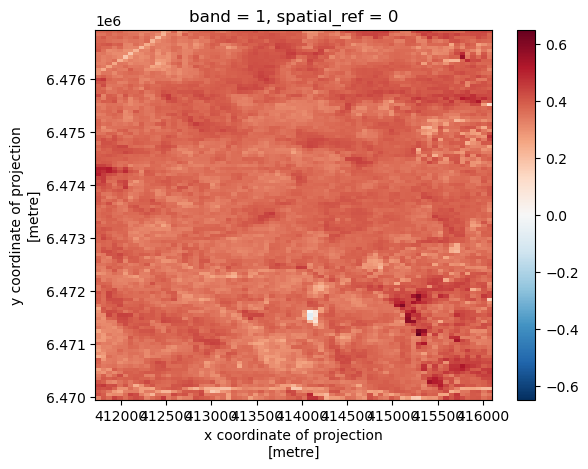

In [29]:
ndvi.plot()

(array([2.000e+00, 2.000e+00, 4.000e+00, 2.100e+01, 2.110e+02, 3.225e+03,
        4.720e+03, 2.540e+02, 2.300e+01, 6.000e+00]),
 array([-0.07388749, -0.00164882,  0.07058985,  0.14282851,  0.21506718,
         0.28730586,  0.35954452,  0.4317832 ,  0.50402188,  0.57626051,
         0.64849919]),
 <BarContainer object of 10 artists>)

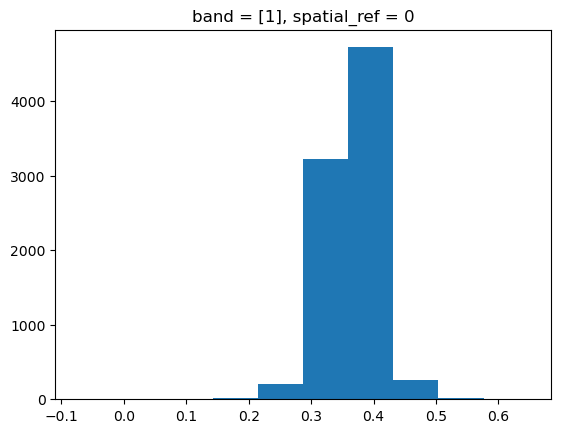

In [27]:
ndvi.plot.hist()

Missing values can be interpolated from the values of neighbouring grid cells using the `.interpolate_na` method. We then save ndvi as a GeoTiff file:

In [33]:
ndvi_nonan = ndvi.interpolate_na(dim="x")
ndvi_nonan.rio.to_raster(join(base_product_dir, "NDVI.tif"))

# Exercise: Explore NDVI Raster Values

It’s often a good idea to explore the range of values in a raster dataset just like we might explore a dataset that we collected in the field. The histogram we just made is a good start but there’s more we can do to improve our understanding of the data.  

1. What is the min and maximum value for the NDVI raster (ndvi) that we just created? Are there missing values?
2. Plot a histogram with 50 bins instead of 8. What do you notice that wasn’t clear before?
3. Plot the ndvi raster using breaks that make sense for the data. (HINT: use the `levels=[bins]` plot parameter)


Note that, by default, each class includes the left but not the right bound. This is not an issue here, since the computed range of NDVI values is fully contained in the open interval (-1; 1) (see exercise above).

In [30]:
import numpy as np
import xarray

# Defines the bins for pixel values
class_bins = (-1, 0., 0.2, 0.7, 1)

# The numpy.digitize function returns an unlabeled array, in this case, a
# classified array without any metadata. That doesn't work--we need the
# coordinates and other spatial metadata. We can get around this using
# xarray.apply_ufunc, which can run the function across the data array while
# preserving metadata.
ndvi_classified = xarray.apply_ufunc(
    np.digitize,
    ndvi_nonan,
    class_bins
)

NameError: name 'ndvi_nonan' is not defined

# Classifying Continuous Rasters in Python 
Now that we have a sense of the distribution of our NDVI raster, we can reduce the complexity of our map by classifying it. Classification involves assigning each pixel in the raster to a class based on its value. In Python, we can accomplish this using the numpy.digitize function.

First, we define NDVI classes based on a list of values, as defined in the last exercise: [-1, 0., 0.2, 0.7, 1]. When bins are ordered from low to high, as here, numpy.digitize assigns classes like so:


![ndvi classes](../notebook_pictures/NDVI-classes.jpg)  
> Source: [Carpentries](https://carpentries-incubator.github.io/geospatial-python/09-raster-calculations.html). CC BY 4.0 License

In [38]:
import numpy as np
import xarray

# Defines the bins for pixel values
class_bins = (-1, 0., 0.2, 0.7, 1)

# The numpy.digitize function returns an unlabeled array, in this case, a
# classified array without any metadata. That doesn't work--we need the
# coordinates and other spatial metadata. We can get around this using
# xarray.apply_ufunc, which can run the function across the data array while
# preserving metadata.
ndvi_classified = xarray.apply_ufunc(
    np.digitize,
    ndvi_nonan,
    class_bins
)

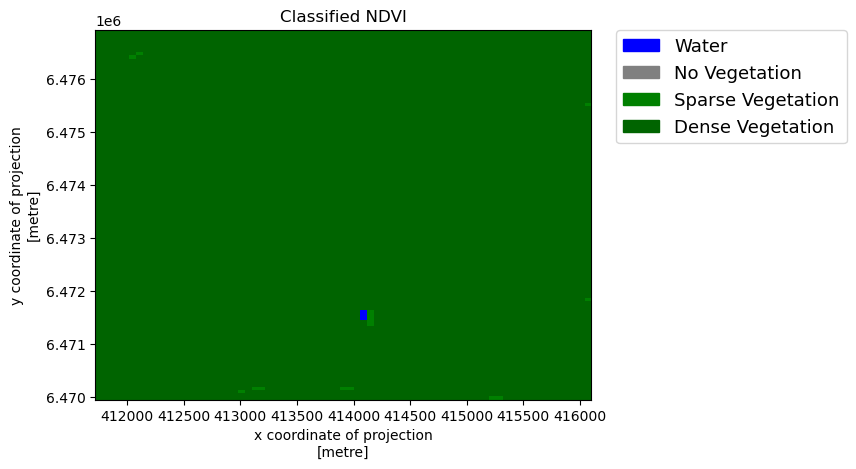

In [37]:
import earthpy.plot as ep
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap

# Define color map of the map legend
ndvi_colors = ["blue", "gray", "green", "darkgreen"]
ndvi_cmap = ListedColormap(ndvi_colors)

# Define class names for the legend
category_names = [
    "Water",
    "No Vegetation",
    "Sparse Vegetation",
    "Dense Vegetation"
]

# We need to know in what order the legend items should be arranged
category_indices = list(range(len(category_names)))

# Make the plot
im = ndvi_classified.plot(cmap=ndvi_cmap, add_colorbar=False)
plt.title("Classified NDVI")
# earthpy helps us by drawing a legend given an existing image plot and legend items, plus indices
ep.draw_legend(im_ax=im, classes=category_indices, titles=category_names)

# Save the figure
plt.savefig("NDVI_classified.png", bbox_inches="tight", dpi=300)


# Key Points

- Python’s built-in math operators are fast and simple options for raster math using xarray's
- numpy.digitize can be used to classify raster values in order to generate a less complicated map.

